# Preprocessing data for paper plots

The data used in this study is far too large to provide the raw data for reproducing the plots, until this workflow is completely cloudified.
In this notebook we process raw data and large preprocessed datasets (like the raw histogram output) into datasets, that can be archived to zenodo and used for plotting.

These cells can only be executed on Princetons [tigressdata]() or [tigercpu]()

## Components

### Depth averages and export maps

The following steps are performed:

- Cut to relevant time (1850-2100)
- Concatenate experiments (historical + ssp 585)
- Filter only members that cover the full time period above
- Concatenate and average members and track member_ids for comparison later
- Some quality control plots
- Regrid to common lat/lon grid
- Mask omz boundary output, so that regions only show where an OMZ with non-zero thickness exists
- Save annual averages into zarr

### Precompute historical average and trend for selected surfaces


### Compute average export in OMZ mask

TODO: Port from Sams notebook for final version


## TODO for final version
- [ ] Catch warnings
- [ ] Integrate STC preprocessing here

In [22]:
import warnings
import pathlib
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

from dask.diagnostics import ProgressBar

from xarrayutils.utils import linear_trend
from cmip6_preprocessing.postprocessing import concat_members
from cmip6_preprocessing.utils import cmip6_dataset_id

from cmip6_omz.omz_tools import mask_basin
from cmip6_omz.units import convert_mol_m3_mymol_kg
from cmip6_omz.upstream_stash import zarr_exists
from busecke_etal_2021_aguadv.utils import (
    load_zarr_directory, fail_age, slope,
    trend_slice, hist_slice, regrid,
    member_treatment
)
from busecke_etal_2021_aguadv.plotting import finish_map_plot

%matplotlib inline

In [15]:
def cut_long_members(ds):
    """Cut members beyong 2100 to avoid issues with dask chunking"""
    if 'time' in ds.dims:
        ds = ds.sel(time=slice(None, '2100'))
    return ds

# TODO: Factor this out into the module (also used in 'Revision Plots')
def make_mask(ds, threshold, var='historical_o2_min_value'):
    # cut all data to a particular threshold
        # convert o2 value units
    o2 = convert_mol_m3_mymol_kg(ds[var])
    if 'time' in o2.dims:
        o2 = o2.mean('time')
    mask = (o2<threshold) # shoulf focus only on the real core
#     mask = (o2.max('time')<threshold) # shoulf focus only on the real core
    return mask

In [16]:
projection = ccrs.Robinson(210)
map_kwargs = dict(x='lon', y='lat', transform=ccrs.PlateCarree())
ifolder = pathlib.Path('/projects/GEOCLIM/LRGROUP/jbusecke/projects/busecke_etal_2021_aguadv/data/processed/plotting')
# ifolder = pathlib.Path('/projects/GEOCLIM/LRGROUP/jbusecke/projects/busecke_etal_2021_aguadv/data/interim/preprocessing_depth_averaged_o2_age')
core_o2=20
outer_o2=120

In [17]:
track_members = {}

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:113: UserWarning: Match attributes ['experiment_id', 'variable_id'] not found in any of the datasets.         This can happen when several combination functions are used.
  warnings.warn(


CanESM5.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


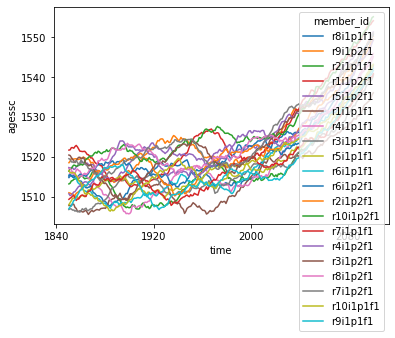

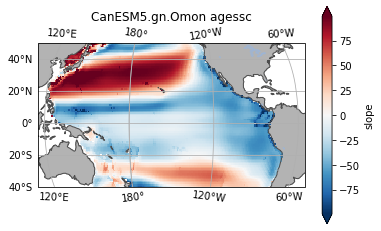

IPSL-CM6A-LR.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


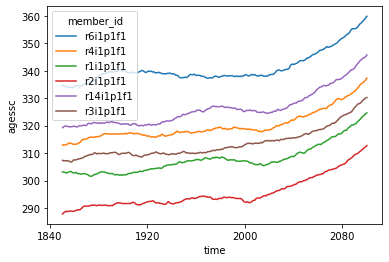

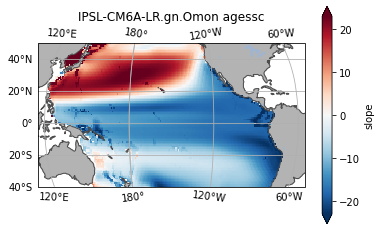

MIROC-ES2L.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


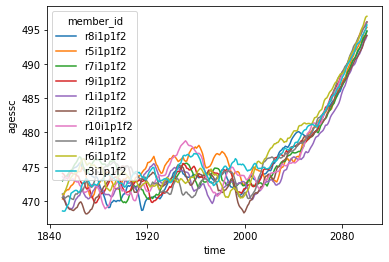

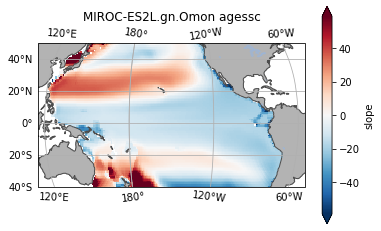

MPI-ESM1-2-LR.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


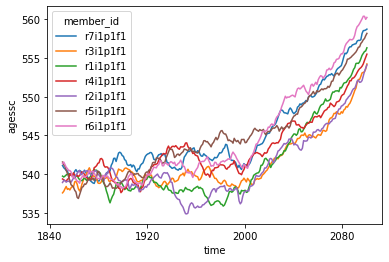

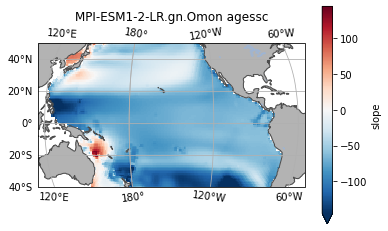

ACCESS-ESM1-5.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


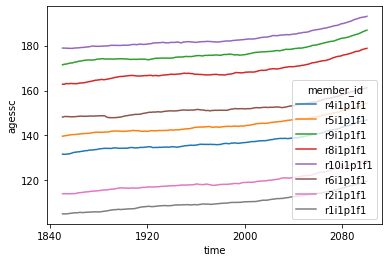

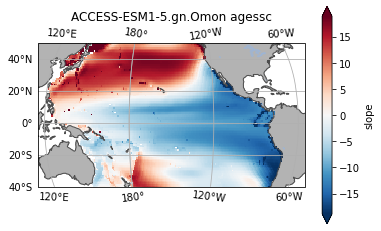

GFDL-CM4.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_

refactor to polish_map?


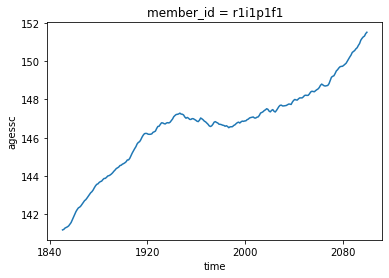

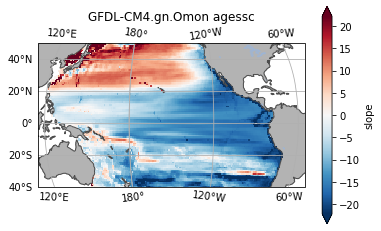

CanESM5-CanOE.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


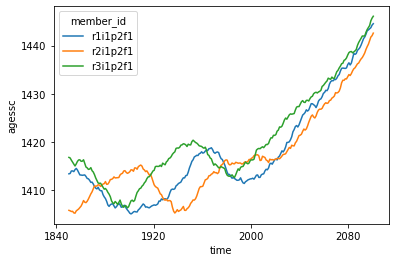

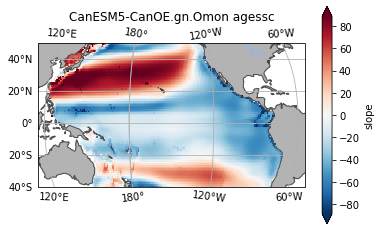

NorESM2-MM.gr.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


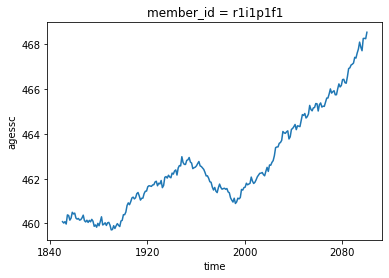

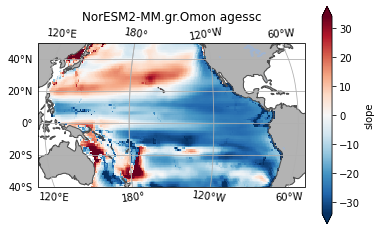

GFDL-ESM4.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


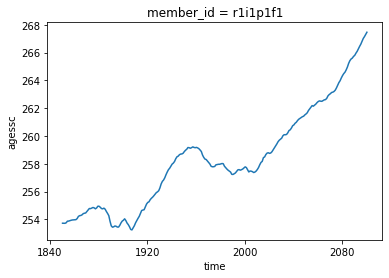

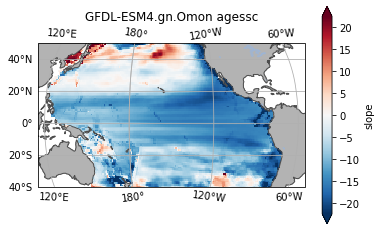

NorESM2-LM.gr.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


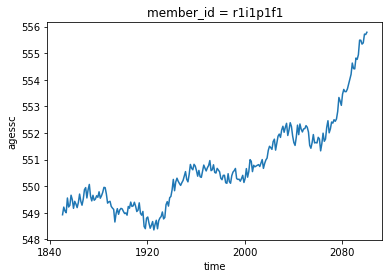

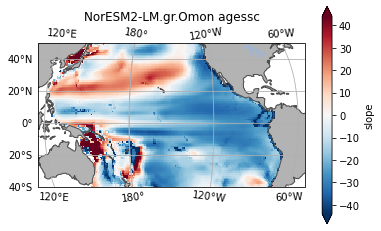

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:113: UserWarning: Match attributes ['experiment_id', 'variable_id'] not found in any of the datasets.         This can happen when several combination functions are used.
  warnings.warn(


CanESM5.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


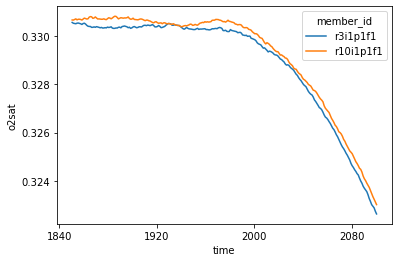

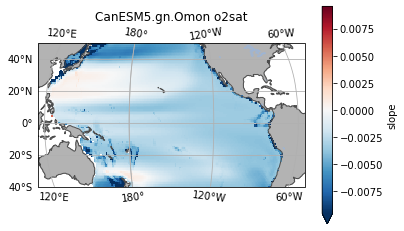

MPI-ESM1-2-LR.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


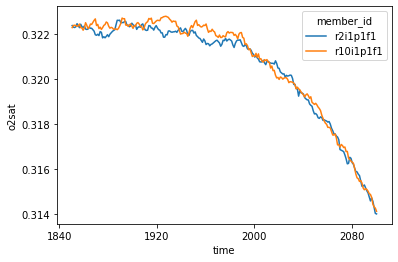

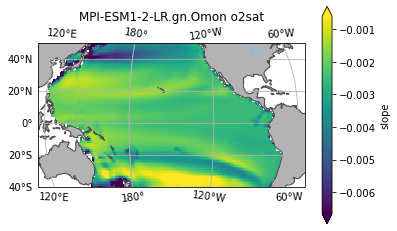

ACCESS-ESM1-5.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


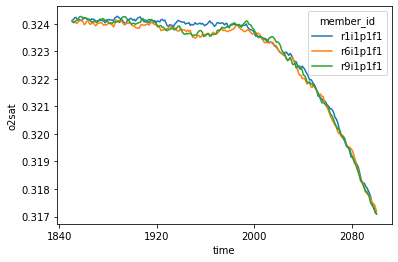

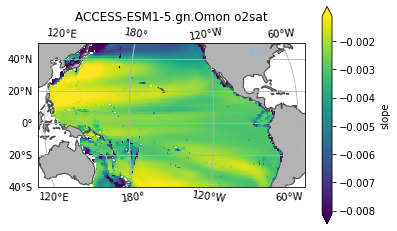

MIROC-ES2L.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


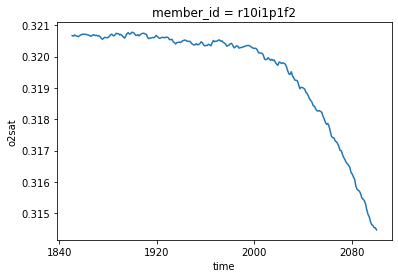

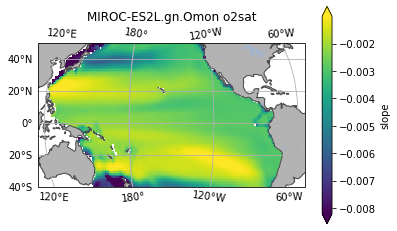

NorESM2-LM.gr.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


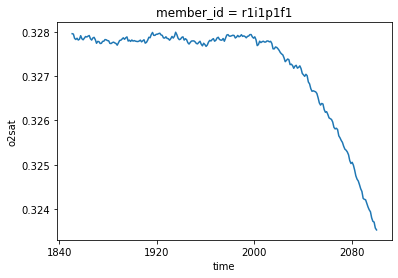

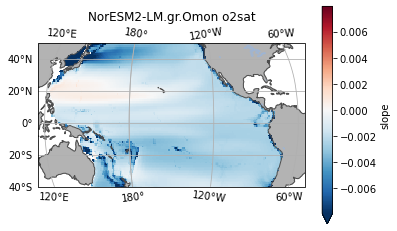

CNRM-ESM2-1.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


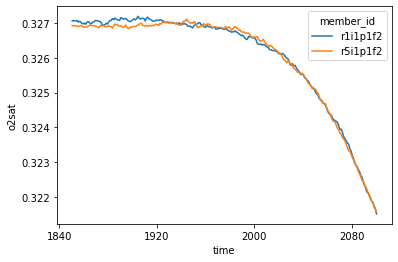

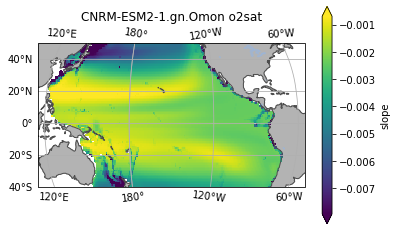

GFDL-ESM4.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


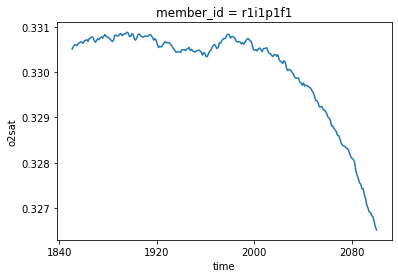

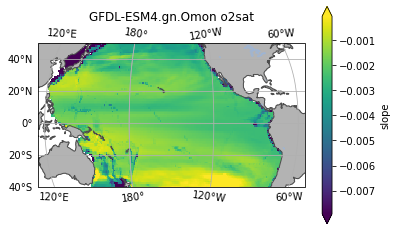

IPSL-CM6A-LR.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


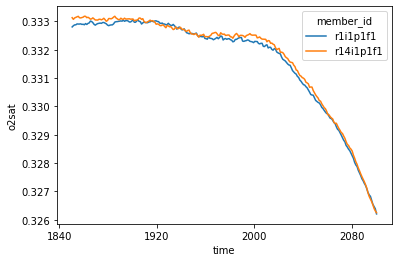

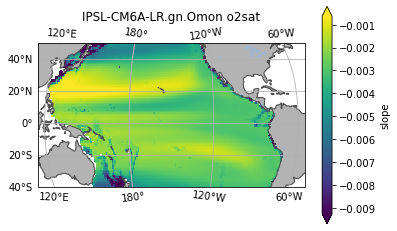

CanESM5-CanOE.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


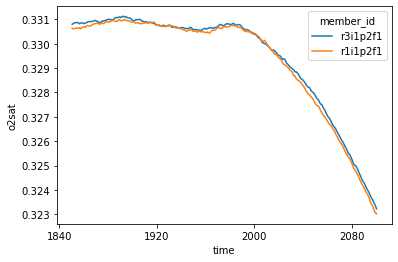

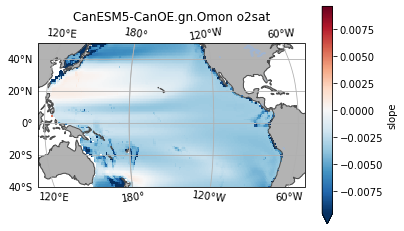

MRI-ESM2-0.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


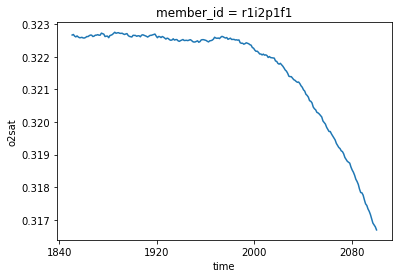

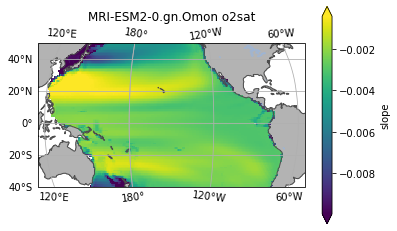

NorESM2-MM.gr.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


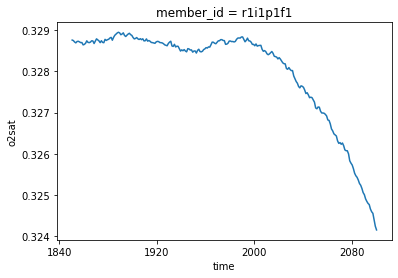

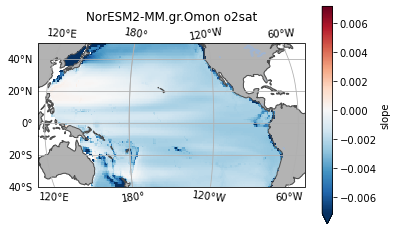

MPI-ESM1-2-HR.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


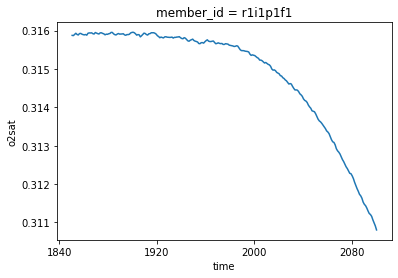

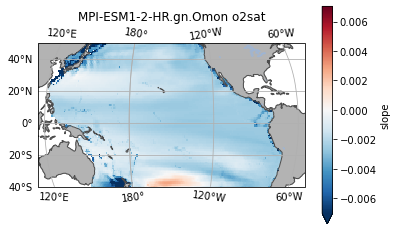

GFDL-CM4.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


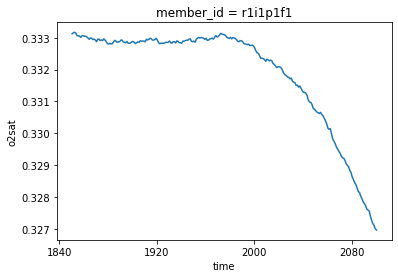

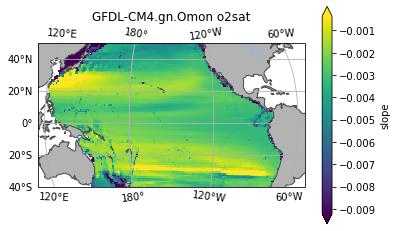

UKESM1-0-LL.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


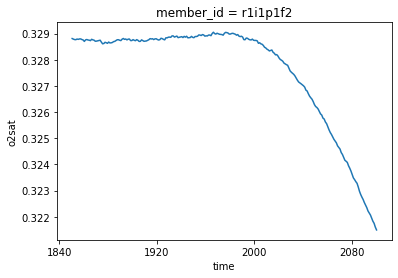

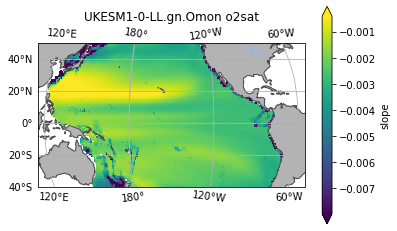

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:113: UserWarning: Match attributes ['experiment_id', 'variable_id'] not found in any of the datasets.         This can happen when several combination functions are used.
  warnings.warn(


ACCESS-ESM1-5.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


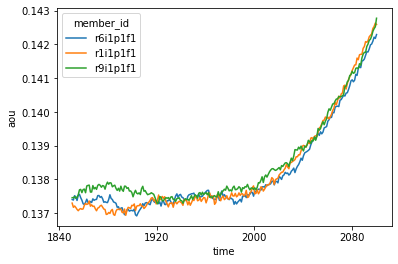

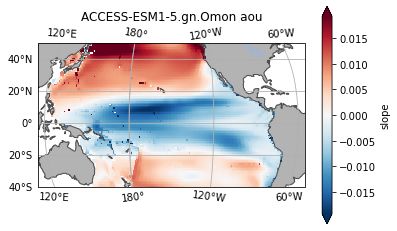

UKESM1-0-LL.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


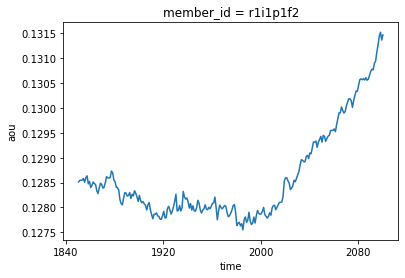

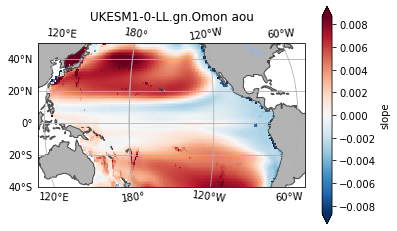

CanESM5-CanOE.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


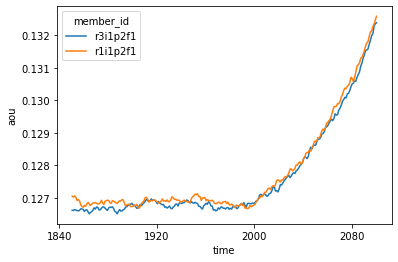

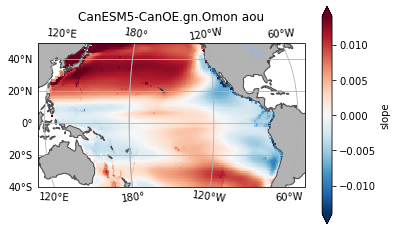

CanESM5.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


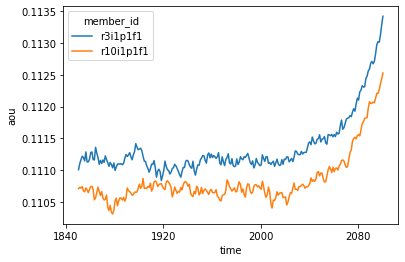

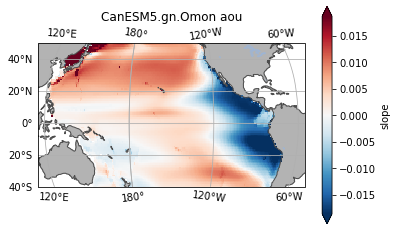

NorESM2-MM.gr.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


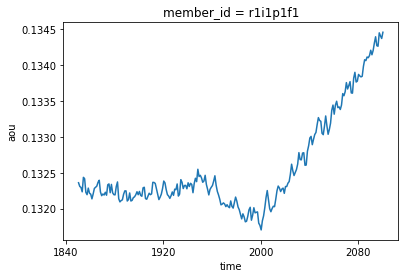

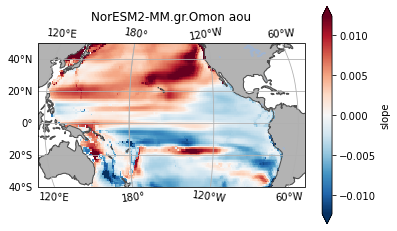

MRI-ESM2-0.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


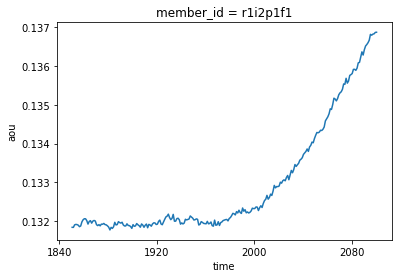

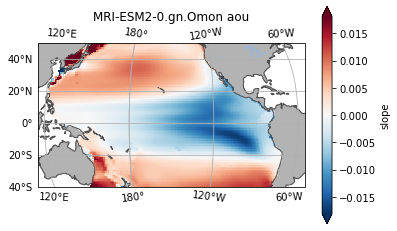

IPSL-CM6A-LR.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


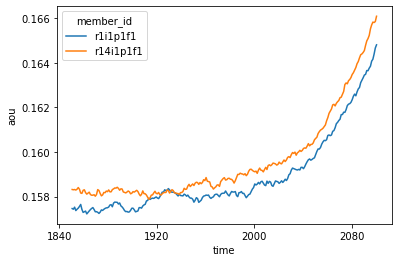

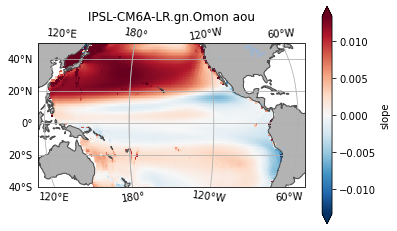

MIROC-ES2L.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


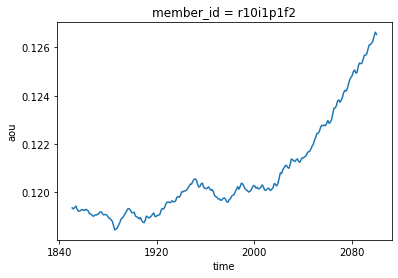

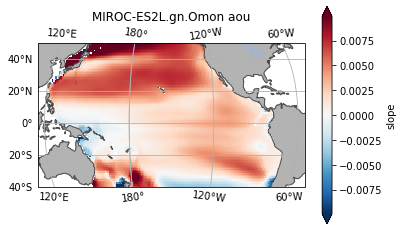

MPI-ESM1-2-LR.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


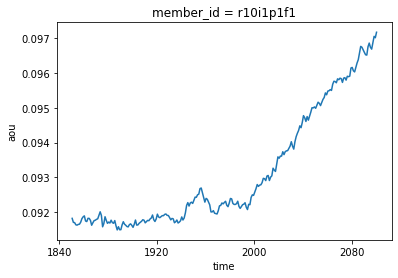

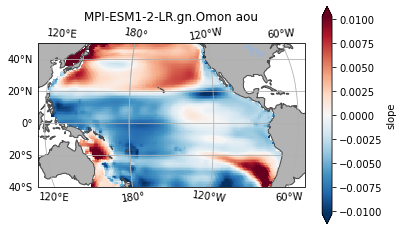

MPI-ESM1-2-HR.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


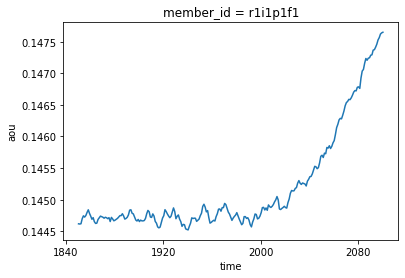

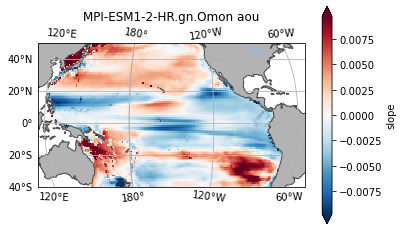

NorESM2-LM.gr.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


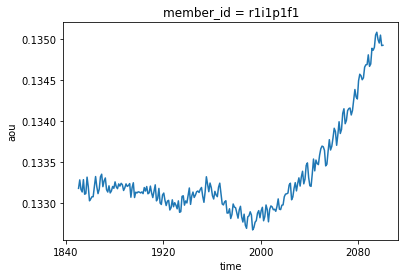

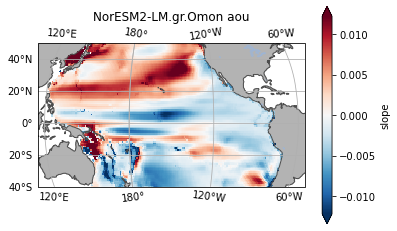

GFDL-CM4.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


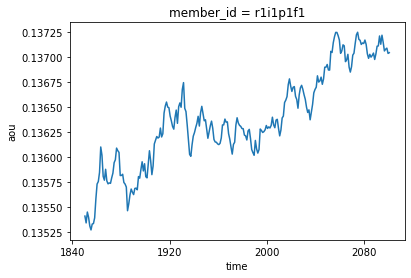

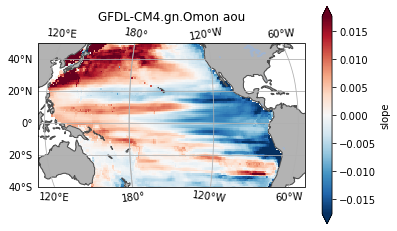

CNRM-ESM2-1.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


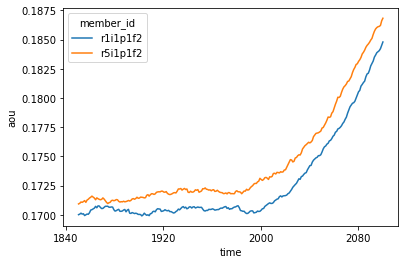

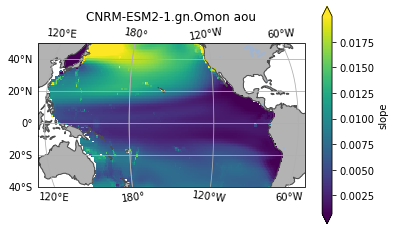

GFDL-ESM4.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


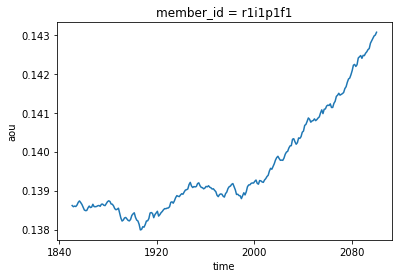

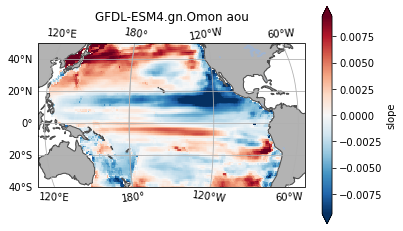

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:113: UserWarning: Match attributes ['experiment_id', 'variable_id'] not found in any of the datasets.         This can happen when several combination functions are used.
  warnings.warn(


ACCESS-ESM1-5.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


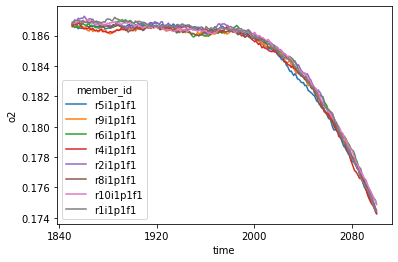

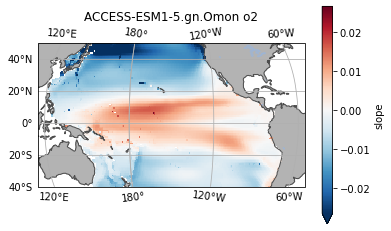

MPI-ESM1-2-LR.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


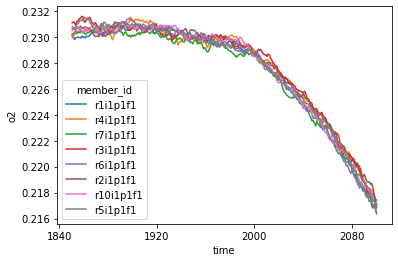

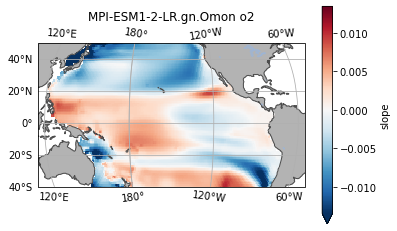

MIROC-ES2L.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


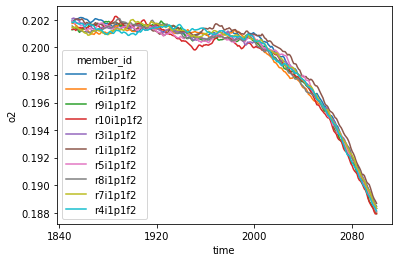

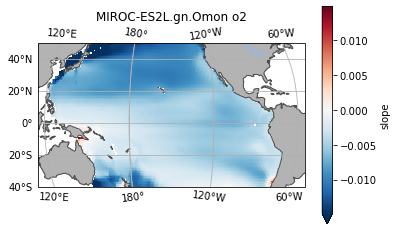

CNRM-ESM2-1.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


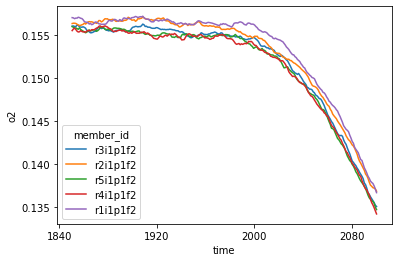

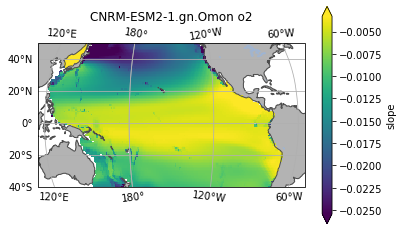

CanESM5.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


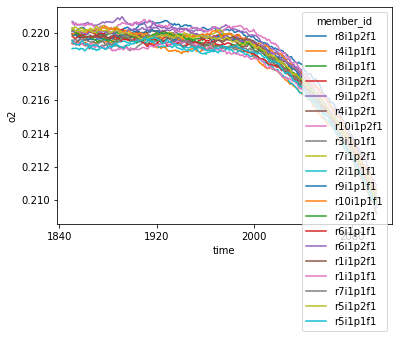

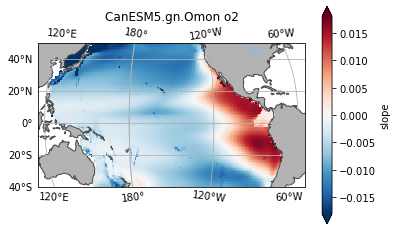

GFDL-ESM4.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


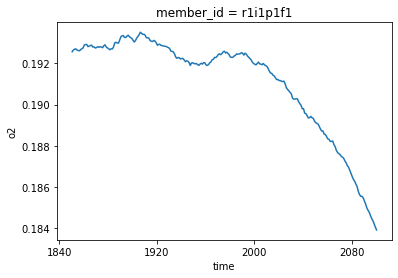

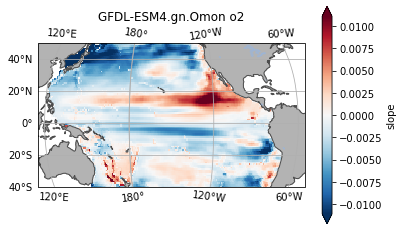

IPSL-CM6A-LR.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


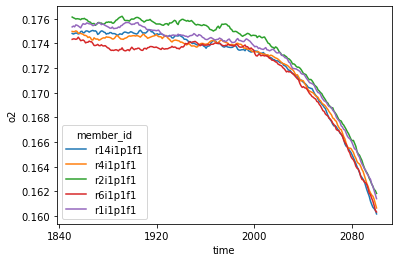

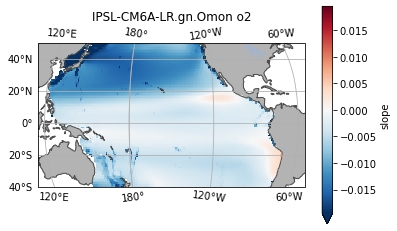

MPI-ESM1-2-HR.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


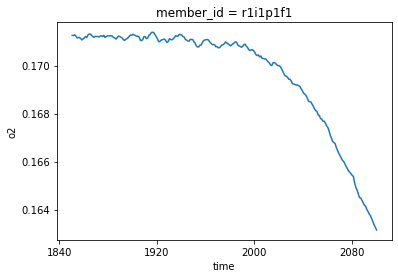

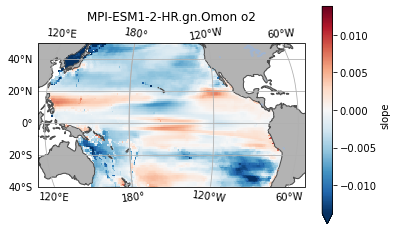

CanESM5-CanOE.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


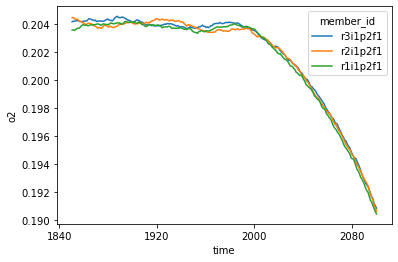

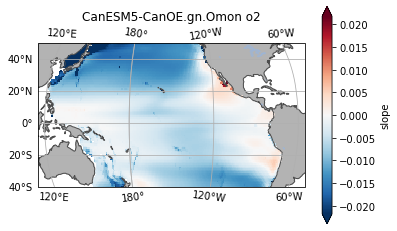

UKESM1-0-LL.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


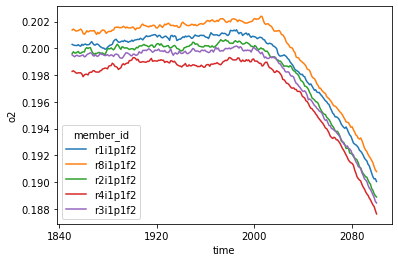

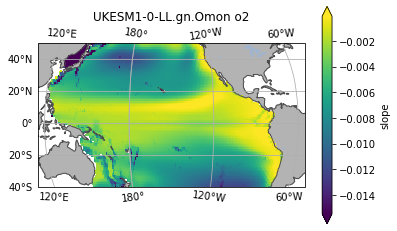

MRI-ESM2-0.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


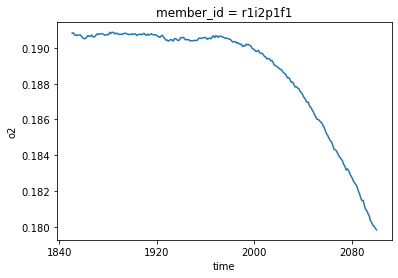

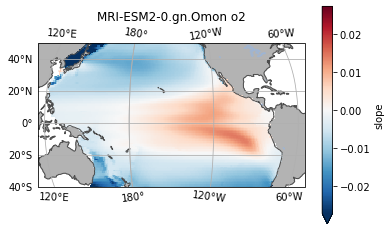

GFDL-CM4.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


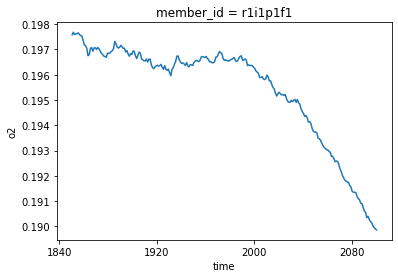

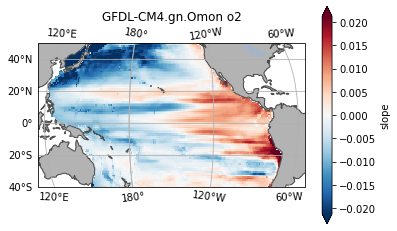

NorESM2-MM.gr.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


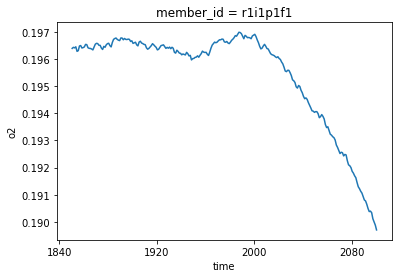

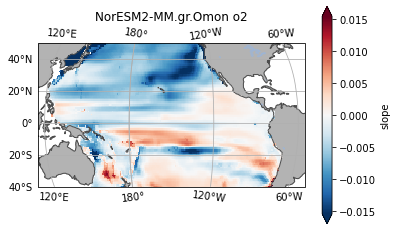

NorESM2-LM.gr.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


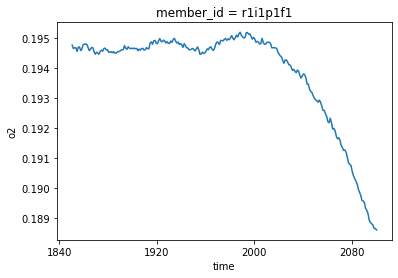

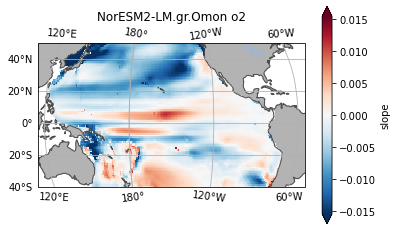

In [19]:
# temp version for o2sat and aou (currently only one member per model)
# version for all o2 models (no matter of age).

depth_pattern = '100-3000m'
path = '/projects/GEOCLIM/LRGROUP/jbusecke/projects_data/cmip6_depth_average_v0.3/'

for var in ['agessc','o2sat', 'aou', 'o2']:

    average_ddict = load_zarr_directory(path, pattern=f'*{depth_pattern}_{var}.zarr')
    
    # some special checks:
    average_ddict = {k:ds for k,ds in average_ddict.items() if len(ds.time) >= 251}
    if var == 'agessc':
        average_ddict = {k:ds for k,ds in average_ddict.items() if not fail_age(ds)}

    track_members[var] = {}

    # There is one wrongly saved file for CM4 (TODO resave that without variable id)
    # for now...
    def _del_attr(ds, attr):
        if attr in ds.attrs.keys():
            del ds.attrs[attr]
        return ds
    average_ddict = {k:_del_attr(ds, 'variable_id') for k, ds in average_ddict.items()}
    average_ddict = concat_members(average_ddict,concat_kwargs={
        'combine_attrs': 'drop_conflicts',
        'compat':'override',
        'coords':'minimal',
    })

    datasets = []

    for k in average_ddict.keys():
        print(k)

        ds = average_ddict[k]

        source_id = ds.source_id
        ds = ds.sel(time=slice('1850', '2100'))
        
        #     # ACCESS has member resolved lon/lat? Ill just overwrite that
        if 'member_id' in ds.lon.dims:
            ds.coords['lon'] = ds['lon'].isel(member_id=0).squeeze()
            ds.coords['lat'] = ds['lat'].isel(member_id=0).squeeze()


        plt.figure()
        ds[var].mean(['x','y']).plot(hue='member_id')

        ds, n_member, member_ids = member_treatment(ds)
        track_members[var][k] = member_ids

        plt.figure()
        try:
            var_slope, _ = slope(ds[var])

            var_slope = regrid(var_slope).load()
            var_slope = mask_basin(var_slope)
            var_slope = var_slope.where(abs(var_slope.lat)<50)

            var_slope.plot(robust=True, subplot_kws=dict(projection=projection), **map_kwargs)

            finish_map_plot(plt.gca())
            plt.title(f"{k} {var}")
            plt.show()

            var_slope = var_slope.assign_coords(n_members = xr.DataArray(n_member, coords={'model':source_id}))

            datasets.append(var_slope)
        except Exception as e:
            print(f'failed for {k} with {e}')

    ds_combo = xr.concat(datasets, 'model')

    ds_combo.to_dataset(name=var).to_zarr(ifolder.joinpath(f"combined_{var}_{depth_pattern}.zarr"), mode='w')

In [13]:
# # version for all o2 models (no matter of age).
# # TODO: Integrate this with other fields?

# depth_pattern = '100-3000m'
# path = '/projects/GEOCLIM/LRGROUP/jbusecke/projects_data/cmip6_depth_average_v0.3/'
# average_o2_ddict = load_zarr_directory(path, pattern=f'*{depth_pattern}_o2.zarr')

# track_members_o2 = {}

# # There is one wrongly saved file for CM4 (TODO resave that without variable id)
# # for now...
# def _del_attr(ds, attr):
#     if attr in ds.attrs.keys():
#         del ds.attrs[attr]
#     return ds
# average_o2_ddict = {k:_del_attr(ds, 'variable_id') for k, ds in average_o2_ddict.items()}
# average_o2_ddict = concat_members(average_o2_ddict)

# datasets_o2 = []

# for k in average_o2_ddict.keys():
#     print(k)

#     ds = average_o2_ddict[k]

#     source_id = ds.source_id
#     ds = ds.sel(time=slice('1850', '2100'))

#     var = 'o2'

#     plt.figure()
#     ds[var].mean(['x','y']).plot(hue='member_id')

#     ds, n_member, member_ids = member_treatment(ds)
#     track_members_o2[k] = member_ids

#     plt.figure()
#     try:
#         var_slope, _ = slope(ds[var])

#         var_slope = regrid(var_slope).load()
#         var_slope = mask_basin(var_slope)
#         var_slope = var_slope.where(abs(var_slope.lat)<50)

#         var_slope.plot(robust=True, subplot_kws=dict(projection=projection), **map_kwargs)

#         finish_map_plot(plt.gca())
#         plt.title(f"{k} {var}")
#         plt.show()

#         var_slope = var_slope.assign_coords(n_members = xr.DataArray(n_member, coords={'model':source_id}))

#         datasets_o2.append(var_slope)
#     except Exception as e:
#         print(f'failed for {k} with {e}')

# ds_combo_o2 = xr.concat(datasets_o2, 'model')

# for prefix, ds in [('o2', ds_combo_o2)]:
#     ds.to_dataset(name=prefix).to_zarr(ifolder.joinpath(f"combined_{prefix}_{depth_pattern}.zarr"), mode='w')

## Same for age

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:113: UserWarning: Match attributes ['experiment_id', 'variable_id'] not found in any of the datasets.         This can happen when several combination functions are used.
  warnings.warn(


CanESM5.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


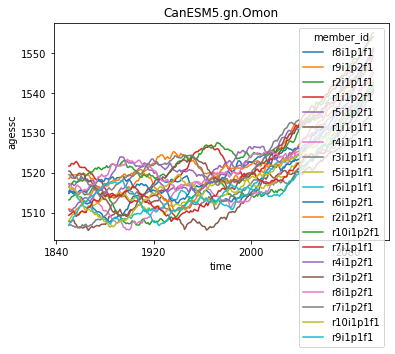

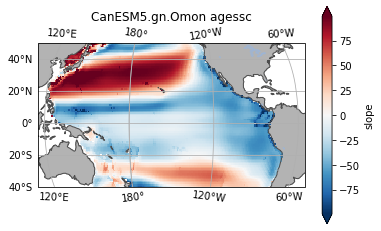

IPSL-CM6A-LR.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


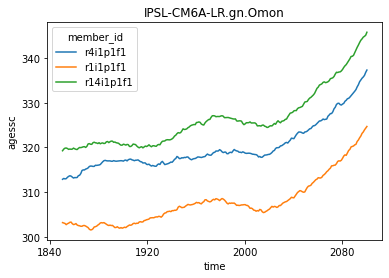

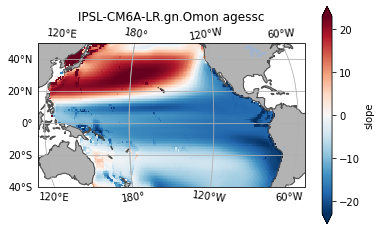

MPI-ESM1-2-LR.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


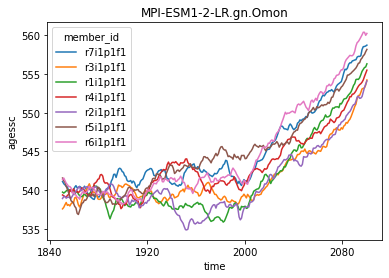

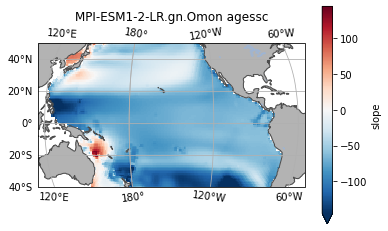

ACCESS-ESM1-5.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


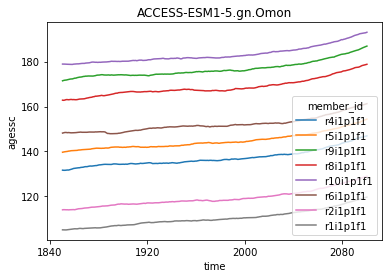

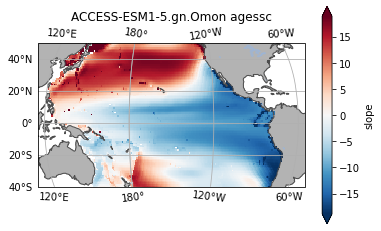

GFDL-CM4.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_

refactor to polish_map?


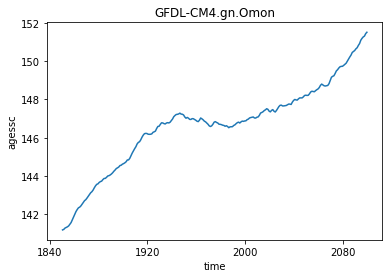

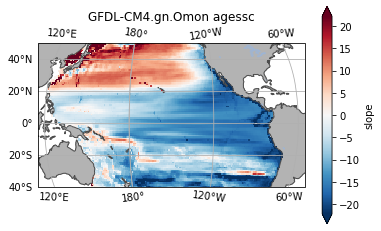

MIROC-ES2L.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


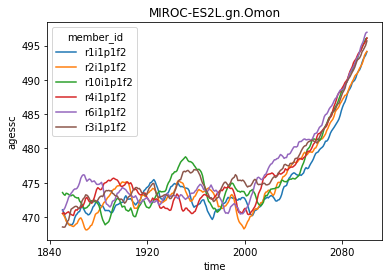

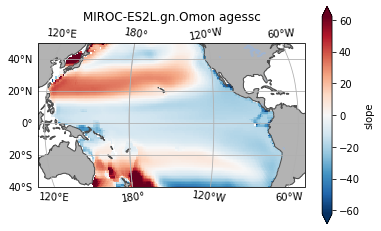

CanESM5-CanOE.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


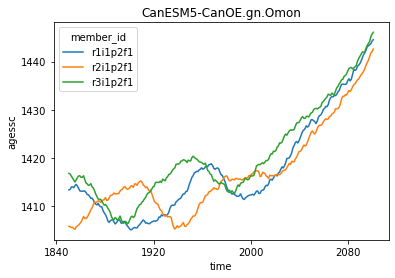

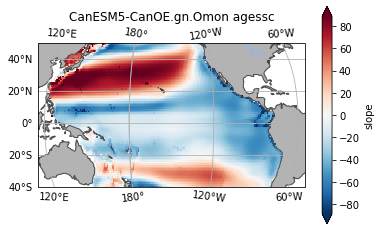

NorESM2-MM.gr.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


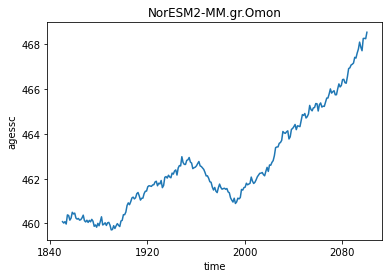

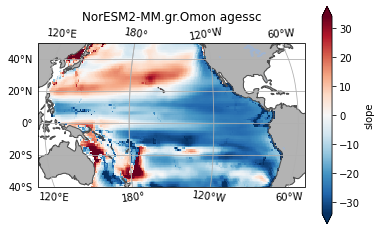

GFDL-ESM4.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


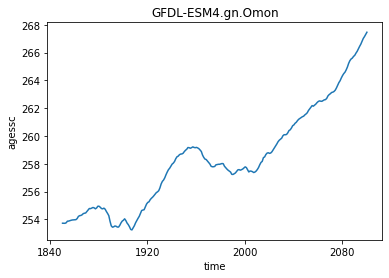

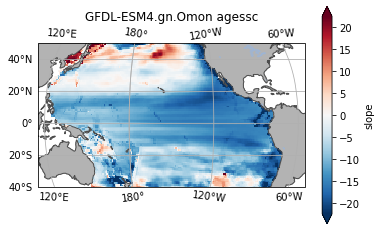

NorESM2-LM.gr.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


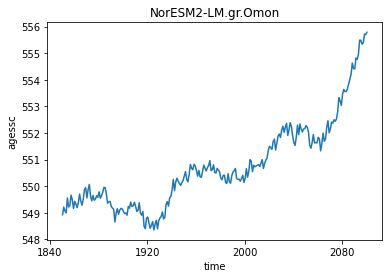

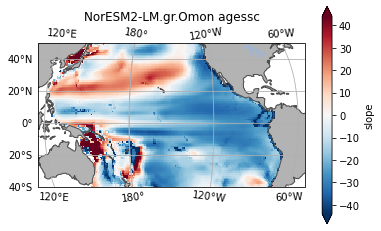

In [55]:
# # version for all age models.
# # TODO: Integrate this with other fields?

# depth_pattern = '100-3000m'
# path = '/projects/GEOCLIM/LRGROUP/jbusecke/projects_data/cmip6_depth_average_v0.3/'
# average_age_ddict = load_zarr_directory(path, pattern=f'*{depth_pattern}_agessc.zarr')

# track_members_age = {}
# average_age_ddict = {k:ds for k,ds in average_age_ddict.items() if not fail_age(ds) and len(ds.time) >= 251}
# average_age_ddict = concat_members(
#     average_age_ddict,
#     concat_kwargs={
#         'combine_attrs': 'drop_conflicts',
# #         'join':'override'
#         'compat':'override',
#         'coords':'minimal',
#     })

# datasets_age = []

# for k in average_age_ddict.keys():
#     print(k)

#     ds = average_age_ddict[k]
    
#     # ACCESS has member resolved lon/lat? Ill just overwrite that
#     if 'member_id' in ds.lon.dims:
#         ds.coords['lon'] = ds['lon'].isel(member_id=0).squeeze()
#         ds.coords['lat'] = ds['lat'].isel(member_id=0).squeeze()
    

#     source_id = ds.source_id
#     ds = ds.sel(time=slice('1850', '2100'))

#     var = 'agessc'

#     plt.figure()
#     ds[var].mean(['x','y']).plot(hue='member_id')
#     plt.title(k)

#     ds, n_member, member_ids = member_treatment(ds)
#     track_members_age[k] = member_ids


#     plt.figure()
#     try:
#         var_slope, _ = slope(ds[var])

#         var_slope = regrid(var_slope).load()
#         var_slope = mask_basin(var_slope)
#         var_slope = var_slope.where(abs(var_slope.lat)<50)

#         var_slope.plot(robust=True, subplot_kws=dict(projection=projection), **map_kwargs)

#         finish_map_plot(plt.gca())
#         plt.title(f"{k} {var}")
#         plt.show()

#         var_slope = var_slope.assign_coords(n_members = xr.DataArray(n_member, coords={'model':source_id}))

#         datasets_age.append(var_slope)
#     except Exception as e:
#         print(f'failed for {k} with {e}')
#         break

# ds_combo_age = xr.concat(datasets_age, 'model')
# ds_combo_age

# for prefix, ds in [('agessc', ds_combo_age)]:
#     ds.to_dataset(name=prefix).to_zarr(ifolder.joinpath(f"combined_{prefix}_{depth_pattern}.zarr"), mode='w')
    
# ds_combo_age

## Same for export

TODO: Homogenize with other processing for final version

In [55]:
path = '/tigress/GEOCLIM/LRGROUP/samjd/global_omz/cmip6_omz/data/external/epc_processed_files2'
flist = list(pathlib.Path(path).glob('*.nc'))
ddict_epc = {f.stem:xr.open_dataset(str(f), chunks={'time':1}) for f in flist}
track_members_epc = {}

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


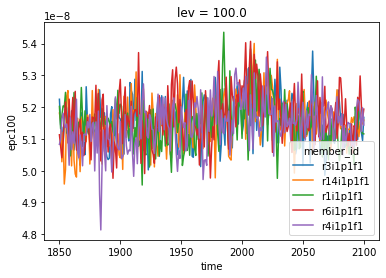

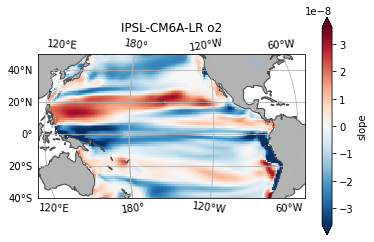

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


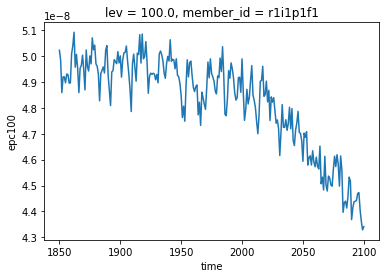

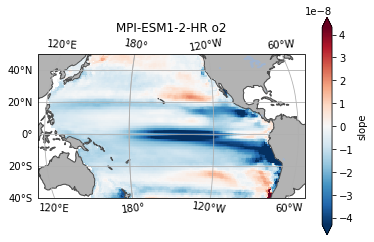

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


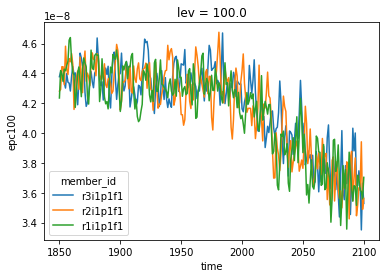

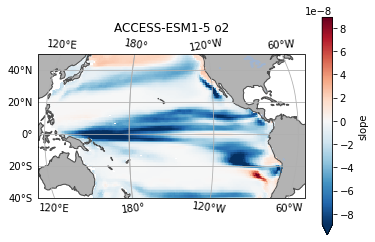

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


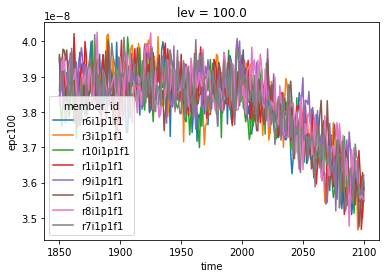

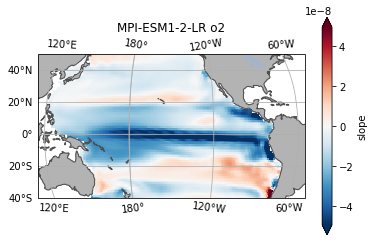

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


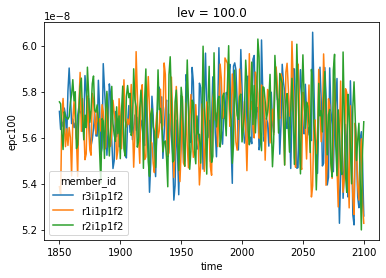

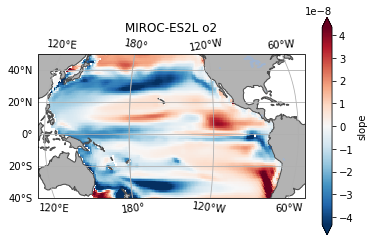

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


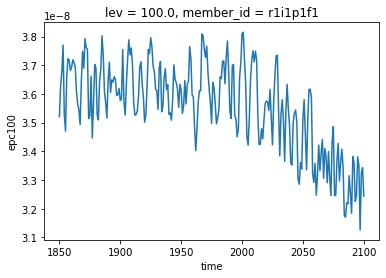

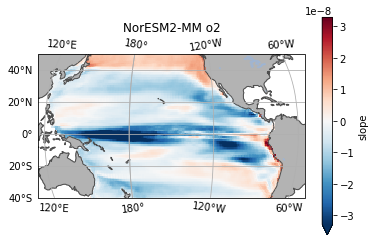

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


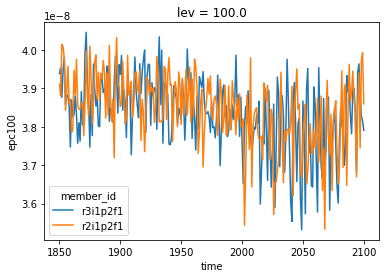

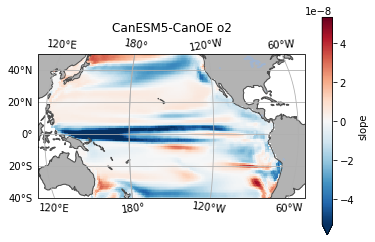

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


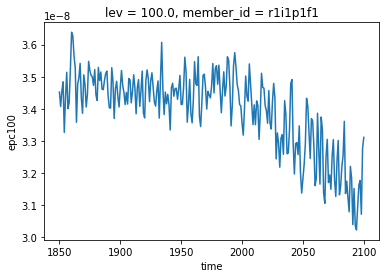

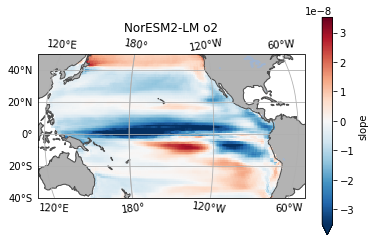

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


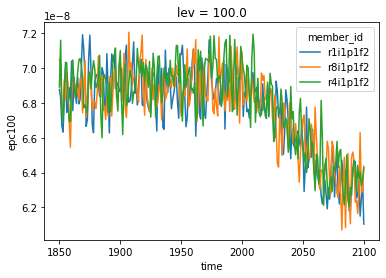

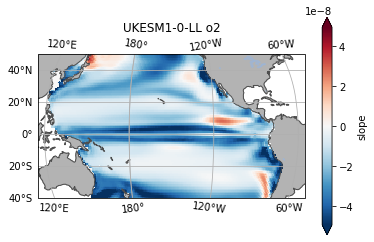

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/smm.

refactor to polish_map?


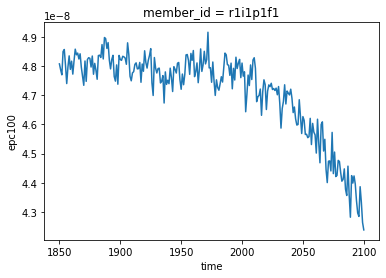

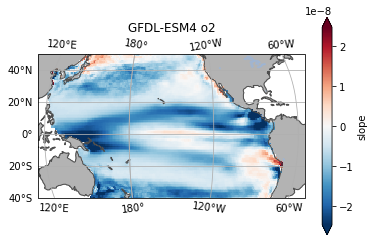

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


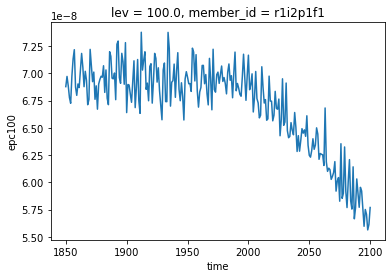

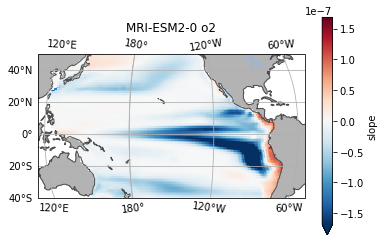

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


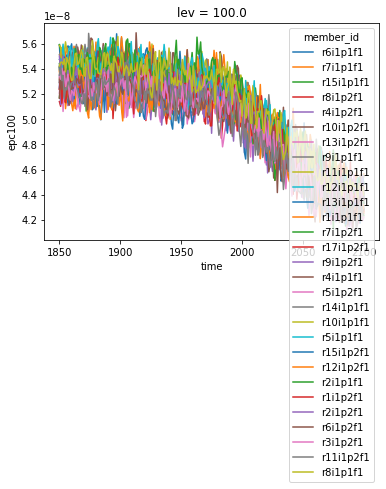

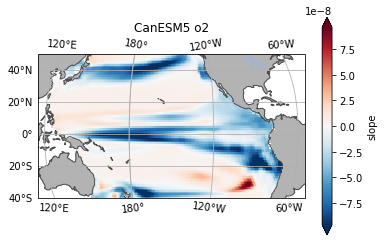

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


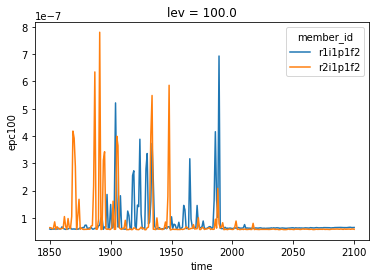

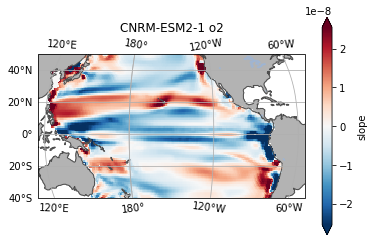

In [56]:
datasets_epc100 = []
for k,ds in ddict_epc.items():
    source_id = ds.source_id
    ds = ds.sel(time=slice('1850', '2100'))
    da = ds.epc100

#     da, _ = slope(ds.epc100)
#     da

    plt.figure()
    da.mean(['x','y']).plot(hue='member_id')

    da, n_members, member_ids = member_treatment(da)
    track_members_epc[k]=member_ids

    
    try:
        var_slope, _ = slope(da)

        var_slope = regrid(var_slope).load()
        var_slope = mask_basin(var_slope)
        var_slope = var_slope.where(abs(var_slope.lat)<50)
        
        plt.figure()
        var_slope.plot(robust=True, subplot_kws=dict(projection=projection), **map_kwargs)
        finish_map_plot(plt.gca())
        plt.title(f"{k} {var}")
        plt.show()

        var_slope = var_slope.assign_coords(n_members = xr.DataArray(n_member, coords={'model':source_id}))

        datasets_epc100.append(var_slope)
    except Exception as e:
        print(f'failed for {k} with {e}')

ds_combo_epc100 = xr.concat(datasets_epc100, 'model', coords='minimal')

for prefix, ds in [('epc100', ds_combo_epc100)]:
    ds.to_dataset(name=prefix).to_zarr(ifolder.joinpath(f"combined_{prefix}_{depth_pattern}.zarr"), mode='w')

## Precompute historical average and trend for selected surfaces

In [21]:
# Boundary data
path = '/projects/GEOCLIM/LRGROUP/jbusecke/projects_data/oxycline/v1.0/'
ddict_temp = load_zarr_directory(path, pattern='*omz_boundary.zarr')
ddict_omz_boundary = concat_members(
    {
        cmip6_dataset_id(ds):cut_long_members(ds) for ds in ddict_temp.values() if len(cut_long_members(ds).time)==251
    }
)
ddict_omz_boundary['obs_bianchi'] = xr.open_zarr(path+'/obs.zarr')
assert len(ddict_omz_boundary) == 15 # make sure all models are there...

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:113: UserWarning: Match attributes ['experiment_id'] not found in any of the datasets.         This can happen when several combination functions are used.
  warnings.warn(


In [ ]:
overwrite=False
datasets_pp = {}
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    for name, ds_raw in ddict_omz_boundary.items():
        attrs = {k:v for k,v in ds_raw.attrs.items()}
        filename = ifolder.joinpath(f"regridded_v0.1/{cmip6_dataset_id(ds_raw)}")
        print(name)
        if (not zarr_exists(filename)) or overwrite:
            # eliminate long runs
            if 'time' in ds_raw.dims:
                ds = ds_raw.sel(time=slice("1850", "2101"))
            else:
                ds = ds_raw

            # only take a few thresholds
            ds = ds.sel(o2_threshold=[core_o2, outer_o2])

            # add thickness
            ds["thickness"] = (
                ds.lower_boundary - ds.upper_boundary
            )
            # mask out data appropriately for each threshold 
            # (TODO: this should be done in the original algo)
            mask_datasets = [
                make_mask(ds, t, var='o2_min_value').assign_coords(o2_threshold=t)
                for t in ds.o2_threshold.data
            ]
            mask = xr.concat(mask_datasets, "o2_threshold")
            ds = ds.where(mask)

            # create new dataset
            ds_out = xr.Dataset()


            # compute trends
            for var in ['thickness', 'upper_boundary', 'lower_boundary']:
                if 'time' in ds.dims:
                    ds_out['trend_'+var] = linear_trend(ds[var], "time").slope * 100
                    ds_out['historical_'+var] = ds[var].sel(time=hist_slice).mean("time")
                else:
                    ds_out['trend_'+var] = xr.ones_like(ds[var])*np.nan
                    ds_out['historical_'+var] = ds[var]

            # add historical minimum o2
            if 'time' in ds.dims:
                ds_out['historical_o2_min_value'] = ds_raw['o2_min_value'].sel(time=hist_slice).mean('time')
            else:
                ds_out['historical_o2_min_value'] = ds_raw['o2_min_value']

            with ProgressBar():
                ds_out = ds_out.load()
            ds_out = regrid(ds_out)
            ds_out = ds_out.chunk({"x": -1})
            ds_out.to_zarr(filename, consolidated=True, mode="w")
            ds_out.attrs = attrs
        else:
            pass
#             print('exists')
        ds_reloaded = xr.open_zarr(
                filename, consolidated=True, use_cftime=True
        ).load()
    
        # quick_fix for a faulty IPSL member
        # TODO: remove and check the raw file (do that for all models actually!)
        if 'IPSL' in attrs.get('source_id', 'none'):
            if 'r3i1p1f1' in ds_reloaded.member_id.data:
                ds_reloaded = ds_reloaded.drop_sel(member_id='r3i1p1f1')
            
        
        ds_reloaded = ds_reloaded.assign_coords(model=attrs.get('source_id', 'obs_bianchi'))
        ds_reloaded = ds_reloaded.expand_dims('model') # TODO should be done above

        datasets_pp[cmip6_dataset_id(ds_raw)] = ds_reloaded


track_members_boundary = {}
for k, ds in datasets_pp.items():
    ds, averaged_members, member_ids = member_treatment(ds)
    ds = ds.assign_coords(
        averaged_members=xr.DataArray(
            [averaged_members],
            dims=ds.model.dims,
            coords=ds.model.coords
        ))
    track_members_boundary[k.split('.')[2]] = member_ids
    datasets_pp[k] = ds

ds_boundary_combined = xr.concat(
    datasets_pp.values(), "model", compat="override", coords="minimal", join="inner"
)
ds_boundary_combined = ds_boundary_combined.sortby('model')
ds_boundary_combined.to_zarr(ifolder.joinpath('boundary_combined.zarr'), mode='w')
ds_boundary_combined

UKESM1-0-LL.gn.Omon.o2
[########################################] | 100% Completed |  1min 12.4s
CNRM-ESM2-1.gn.Omon.o2
[########################################] | 100% Completed |  1min 14.0s
CanESM5-CanOE.gn.Omon.o2
[########################################] | 100% Completed | 40.1s
GFDL-CM4.gr.Omon.o2
[########################################] | 100% Completed | 12.4s
MPI-ESM1-2-HR.gn.Omon.o2
[########################################] | 100% Completed | 22.6s
CanESM5.gn.Omon.o2
[###################                     ] | 48% Completed |  3min  3.9s

In [25]:
## Compare missing members
# TODO: Refactor this for final release
models = track_members_o2.keys()
for m in models:
    print('----------------')
    print(m)
    m_epc = m.split('.')[0]
    if m_epc not in track_members_epc.keys():
        print(f"{m_epc} not found in epc dict")
    else:
        epc_members = track_members_epc[m_epc]
    
        o2_members = track_members_o2[m]


        missed_members = set(epc_members).symmetric_difference(set(o2_members))
        if len(missed_members)==0:
            print(f"Export_dict: {m_epc} OK")
        else:
            print(f"Export_dict: {m_epc} didnt find {missed_members}")
    
    m_boundary = m_epc
    if m_boundary not in track_members_boundary.keys():
        print(f"{m_epc} not found in boundary dict")
    else:
        boundary_members = track_members_boundary[m_boundary]
    
        o2_members = track_members_o2[m]


        missed_members = set(boundary_members).symmetric_difference(set(o2_members))
        if len(missed_members)==0:
            print(f"Boundary_dict: {m_epc} OK")
        else:
            print(f"Boundary_dict: {m_epc} didnt find {missed_members}")
            print(set(o2_members))
            
    if m_boundary not in track_members_boundary.keys():
        print(f"{m_epc} not found in boundary dict")
    else:
        boundary_members = track_members_boundary[m_boundary]
    
        o2_members = track_members_o2[m]


        missed_members = set(boundary_members).symmetric_difference(set(o2_members))
        if len(missed_members)==0:
            print(f"Boundary_dict: {m_epc} OK")
        else:
            print(f"Boundary_dict: {m_epc} didnt find {missed_members}")
            print('o2',set(o2_members))

NameError: name 'track_members_o2' is not defined